# Setup

In [1]:
import gc
gc.enable()

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

from tensorflow import keras
from keras.applications import (
    mobilenet_v2, efficientnet_v2, vgg19)
from keras.layers import (
    Resizing, RandomFlip, RandomRotation,
    GlobalAveragePooling2D, Dropout, Dense, Input)

from keras.callbacks import EarlyStopping
from keras.utils import set_random_seed

SEED = 2024
set_random_seed(SEED)

**<-- Mount Drive manually**

In [2]:
DATA_PATH = '/content/drive/MyDrive/notebooks/swoc_s4/facial_emotion_detection/'
images = np.load(f'{DATA_PATH}/images.npy')
labels = np.load(f'{DATA_PATH}/labels.npy')

# Data preparation

In [3]:
label_mapping = {0: 'angry', 1: 'happy', 2: 'neutral', 3: 'surprised'}

In [4]:
ord_labels = np.argmax(labels, axis=1)

**Test dataset:** (using the same split as the baseline notebook)

In [5]:
train_images, test_images, train_labels, test_labels = train_test_split(
    images, ord_labels,
    test_size=0.1,
    shuffle=True,
    stratify=ord_labels, # to maintain proportion of classes in test data
    random_state=SEED)

**Train and validation datasets:**

In [6]:
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels,
    test_size=0.1,
    shuffle=True,
    stratify=train_labels, # to maintain proportion of classes in val data
    random_state=SEED)

In [7]:
len(train_labels), len(val_labels), len(test_labels)

(16159, 1796, 1995)

**Data-augmentation (best config chosen from notebook 01):**

In [8]:
data_augmentation = keras.Sequential([
    RandomRotation(factor=(-0.1, 0.2), fill_mode='constant', seed=SEED),
    RandomFlip(mode='horizontal', seed=SEED),
])

# Model training

In [9]:
# common parameters
BASE_LR = 1e-4
DROPOUT = 0.2
PATIENCE = 10
BATCH_SIZE = 32
EPOCHS = 200
VERBOSE = 0

In [10]:
# overfitting detection
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=PATIENCE,
    min_delta=2e-4,
    restore_best_weights=True)

In [11]:
# visualizing training curves
def plot_training_curve(history):
    train_loss = history.history['loss']
    train_accuracy = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_accuracy = history.history['val_accuracy']
    num_epochs = len(train_loss)
    epochs = range(num_epochs)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharex=True)
    ax[0].plot(epochs, train_loss, label='train_loss')
    ax[0].plot(epochs, val_loss, label='val_loss')
    ax[0].set_title('Loss')
    ax[1].plot(epochs, train_accuracy, label='train_accuracy')
    ax[1].plot(epochs, val_accuracy, label='val_accuracy')
    ax[1].set_title('Accuracy')

    train_stop = (num_epochs-1-PATIENCE, val_accuracy[num_epochs-1-PATIENCE])
    ax[1].annotate(f'Early stopping\ntriggered',
                xy=train_stop, xycoords='data',
                xytext=(-5, -75), textcoords='offset points',
                arrowprops=dict(facecolor='black', shrink=0.05),
                horizontalalignment='center', verticalalignment='bottom')

    ax[0].minorticks_on(); ax[1].minorticks_on()
    ax[0].set_xlabel('Epochs'); ax[1].set_xlabel('Epochs')
    ax[0].legend(); ax[1].legend()
    fig.tight_layout()
    plt.show()

### 1. MobileNetV2, no data augmentation

In [12]:
img_size = 224

**Feature extraction phase:**

In [13]:
keras.backend.clear_session()
preprocess_input = mobilenet_v2.preprocess_input
base_model = mobilenet_v2.MobileNetV2(input_shape=(img_size, img_size, 3), include_top=False)
base_model.trainable = False

inputs = Input(shape=(48, 48, 3))
x = Resizing(img_size, img_size, interpolation='lanczos5', crop_to_aspect_ratio=True)(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
# x = Dropout(DROPOUT)(x)
# x = Dense(64, activation='relu')(x)
x = Dropout(DROPOUT)(x)
outputs = Dense(4, activation='softmax')(x)

model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=BASE_LR),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

9406464/9406464 [==============================] - 0s 0us/step


Epoch 1/100
505/505 [==============================] - 94s 160ms/step - loss: 1.5501 - accuracy: 0.3243 - val_loss: 1.3957 - val_accuracy: 0.3614
Epoch 2/100
505/505 [==============================] - 79s 156ms/step - loss: 1.4817 - accuracy: 0.3446 - val_loss: 1.3379 - val_accuracy: 0.3909
Epoch 3/100
505/505 [==============================] - 78s 155ms/step - loss: 1.4248 - accuracy: 0.3706 - val_loss: 1.2928 - val_accuracy: 0.4254
Epoch 4/100
505/505 [==============================] - 78s 154ms/step - loss: 1.3833 - accuracy: 0.3886 - val_loss: 1.2565 - val_accuracy: 0.4438
Epoch 5/100
505/505 [==============================] - 77s 153ms/step - loss: 1.3447 - accuracy: 0.4047 - val_loss: 1.2268 - val_accuracy: 0.4605
Epoch 6/100
505/505 [==============================] - 78s 154ms/step - loss: 1.3134 - accuracy: 0.4253 - val_loss: 1.2025 - val_accuracy: 0.4710
Epoch 7/100
505/505 [==============================] - 78s 155ms/step - loss: 1.2857 - accuracy: 0.4370 - val_loss: 1.1810 -

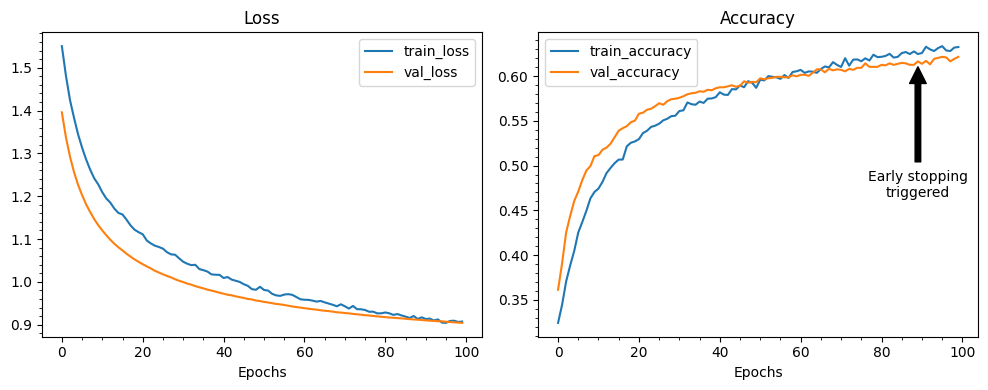

CPU times: user 1h 30min 20s, sys: 2min 21s, total: 1h 32min 41s
Wall time: 2h 9min 29s


In [14]:
%%time
history = model.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping],
    verbose=VERBOSE)

plot_training_curve(history)

In [15]:
print('VALIDATION:')
model.evaluate(val_images, val_labels)
print('\nTEST:')
model.evaluate(test_images, test_labels)

VALIDATION:
57/57 [==============================] - 8s 138ms/step - loss: 0.9044 - accuracy: 0.6214

TEST:
63/63 [==============================] - 8s 133ms/step - loss: 0.9166 - accuracy: 0.6311


[0.9165595769882202, 0.6310777068138123]

63/63 [==============================] - 8s 115ms/step


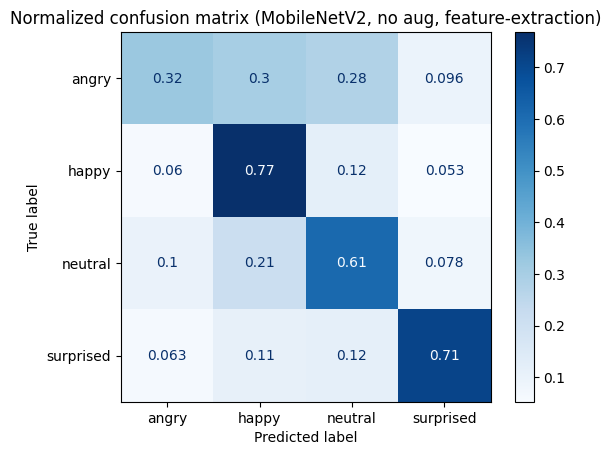

In [16]:
predictions = np.argmax(model.predict(test_images), axis=1)

disp = ConfusionMatrixDisplay.from_predictions(
    test_labels, predictions,
    display_labels=label_mapping.values(),
    cmap=plt.cm.Blues,
    normalize='true')

disp.ax_.set_title('Normalized confusion matrix (MobileNetV2, no aug, feature-extraction)')
plt.show()

**Fine-tuning phase:**

In [17]:
base_model.trainable = True

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=BASE_LR/10),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

Epoch 1/100
505/505 [==============================] - 153s 251ms/step - loss: 0.8711 - accuracy: 0.6500 - val_loss: 0.8540 - val_accuracy: 0.6487
Epoch 2/100
505/505 [==============================] - 121s 239ms/step - loss: 0.8171 - accuracy: 0.6718 - val_loss: 0.8279 - val_accuracy: 0.6620
Epoch 3/100
505/505 [==============================] - 119s 236ms/step - loss: 0.7858 - accuracy: 0.6888 - val_loss: 0.8087 - val_accuracy: 0.6726
Epoch 4/100
505/505 [==============================] - 121s 239ms/step - loss: 0.7607 - accuracy: 0.6975 - val_loss: 0.7858 - val_accuracy: 0.6860
Epoch 5/100
505/505 [==============================] - 124s 245ms/step - loss: 0.7297 - accuracy: 0.7139 - val_loss: 0.7680 - val_accuracy: 0.6965
Epoch 6/100
505/505 [==============================] - 124s 246ms/step - loss: 0.7151 - accuracy: 0.7202 - val_loss: 0.7544 - val_accuracy: 0.6982
Epoch 7/100
505/505 [==============================] - 124s 246ms/step - loss: 0.6937 - accuracy: 0.7286 - val_loss: 0

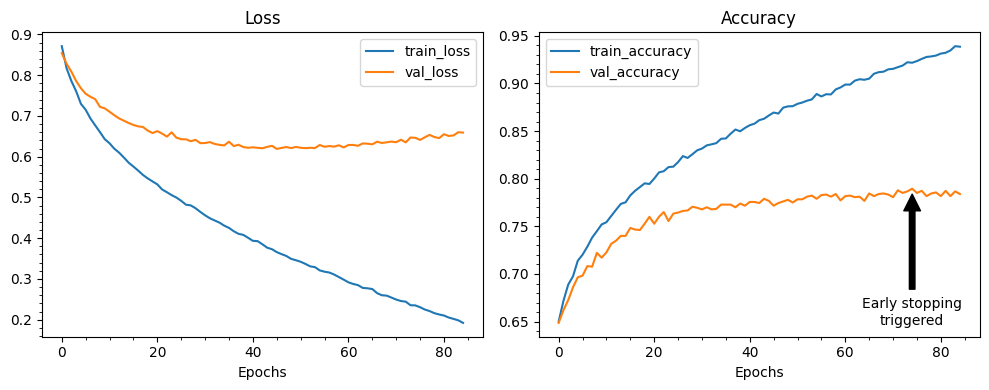

CPU times: user 2h 26min 30s, sys: 2min 7s, total: 2h 28min 38s
Wall time: 2h 59min 55s


In [18]:
%%time
history_ft = model.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping],
    verbose=VERBOSE)

plot_training_curve(history_ft)

In [19]:
print('VALIDATION:')
model.evaluate(val_images, val_labels)
print('\nTEST:')
model.evaluate(test_images, test_labels)

VALIDATION:
57/57 [==============================] - 8s 131ms/step - loss: 0.6463 - accuracy: 0.7895

TEST:
63/63 [==============================] - 10s 159ms/step - loss: 0.6539 - accuracy: 0.7779


[0.6539287567138672, 0.7779448628425598]

In [ ]:
predictions = np.argmax(model.predict(test_images), axis=1)

disp = ConfusionMatrixDisplay.from_predictions(
    test_labels, predictions,
    display_labels=label_mapping.values(),
    cmap=plt.cm.Blues,
    normalize='true')

disp.ax_.set_title('Normalized confusion matrix (MobileNetV2, no aug, fine-tuning)')
plt.show()

### 2. MobileNetV2, with data augmentation

**Feature extraction phase:**

In [21]:
keras.backend.clear_session()
preprocess_input = mobilenet_v2.preprocess_input
base_model = mobilenet_v2.MobileNetV2(input_shape=(img_size, img_size, 3), include_top=False)
base_model.trainable = False

inputs = Input(shape=(48, 48, 3))
x = Resizing(img_size, img_size, interpolation='lanczos5', crop_to_aspect_ratio=True)(inputs)
x = preprocess_input(x)
x = data_augmentation(x)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
# x = Dropout(DROPOUT)(x)
# x = Dense(64, activation='relu')(x)
x = Dropout(DROPOUT)(x)
outputs = Dense(4, activation='softmax')(x)

model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=BASE_LR),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
%%time
history = model.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping],
    verbose=VERBOSE)

plot_training_curve(history)

Epoch 1/100
505/505 [==============================] - 85s 162ms/step - loss: 1.6282 - accuracy: 0.2969 - val_loss: 1.4093 - val_accuracy: 0.3185
Epoch 2/100
505/505 [==============================] - 81s 161ms/step - loss: 1.5143 - accuracy: 0.3308 - val_loss: 1.3624 - val_accuracy: 0.3502
Epoch 3/100
505/505 [==============================] - 83s 164ms/step - loss: 1.4588 - accuracy: 0.3478 - val_loss: 1.3199 - val_accuracy: 0.3847
Epoch 4/100
505/505 [==============================] - 81s 161ms/step - loss: 1.4205 - accuracy: 0.3724 - val_loss: 1.2889 - val_accuracy: 0.4126
Epoch 5/100
505/505 [==============================] - 81s 160ms/step - loss: 1.3824 - accuracy: 0.3902 - val_loss: 1.2643 - val_accuracy: 0.4371
Epoch 6/100
505/505 [==============================] - 84s 166ms/step - loss: 1.3467 - accuracy: 0.4029 - val_loss: 1.2441 - val_accuracy: 0.4465
Epoch 7/100
505/505 [==============================] - 80s 158ms/step - loss: 1.3248 - accuracy: 0.4157 - val_loss: 1.2300 -

In [ ]:
print('VALIDATION:')
model.evaluate(val_images, val_labels)
print('\nTEST:')
model.evaluate(test_images, test_labels)

In [ ]:
predictions = np.argmax(model.predict(test_images), axis=1)

disp = ConfusionMatrixDisplay.from_predictions(
    test_labels, predictions,
    display_labels=label_mapping.values(),
    cmap=plt.cm.Blues,
    normalize='true')

disp.ax_.set_title('Normalized confusion matrix (MobileNetV2, data aug, feature-extraction)')
plt.show()

**Fine-tuning phase:**

In [ ]:
base_model.trainable = True

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=BASE_LR/10),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
%%time
history_ft = model.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping],
    verbose=VERBOSE)

plot_training_curve(history_ft)

In [ ]:
print('VALIDATION:')
model.evaluate(val_images, val_labels)
print('\nTEST:')
model.evaluate(test_images, test_labels)

In [ ]:
predictions = np.argmax(model.predict(test_images), axis=1)

disp = ConfusionMatrixDisplay.from_predictions(
    test_labels, predictions,
    display_labels=label_mapping.values(),
    cmap=plt.cm.Blues,
    normalize='true')

disp.ax_.set_title('Normalized confusion matrix (MobileNetV2, data aug, fine-tuning)')
plt.show()